In [1]:
from SymPT import *
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.linalg as la

In [2]:
#plt.style.use("classic")
cmap = plt.get_cmap('inferno')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', weight = 'normal')
plt.rc('font', size = 18)
color_list = [cmap(i) for i in np.linspace(0, 1, 16)]
fntsize = 20
dir_images = "graphs/"

In [3]:
def get_structure(block_sizes):
    """
    Generate a block structure with specified block sizes.
    
    Parameters:
    -----------
    block_sizes : list of int
        List of block sizes for each section of the matrix
        
    Returns:
    --------
    structure : numpy.ndarray
        The generated block structure matrix
    """
    # functions for generating blocks
    block = lambda i, j: np.ones((i, j))
    zero = lambda i, j: np.zeros((i, j))
    
    
    n = len(block_sizes) # initial block structure
    structure = []
    
    for i in range(n):
        row = []
        for j in range(n):
            # Fill with zeros if i > j (lower triangle)
            if i > j:
                row.append(zero(block_sizes[i], block_sizes[j]))
            # Create block of ones for diagonal
            elif i == j:
                row.append(zero(block_sizes[i], block_sizes[j]))
            # Fill with ones for upper triangle
            else:
                row.append(block(block_sizes[i], block_sizes[j]))
        structure.append(row)
    

    structure = np.block(structure) # Convert to numpy block matrix
    
    structure = structure + structure.T # Make symmetric 
    
    return structure

# Mask

(7, 7)

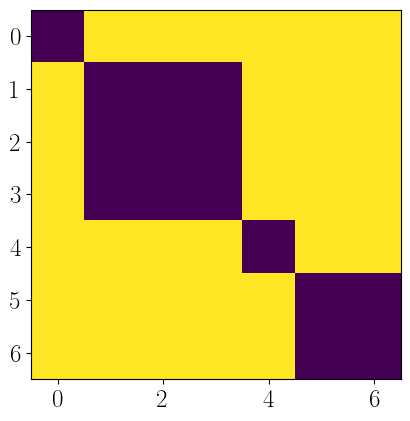

In [9]:
b_dims = np.random.randint(5, size=5)
structure = get_structure(b_dims)
mask = Block(structure)
plt.imshow(structure)
structure.shape

# Hamiltonian

In [10]:
I = structure.shape[0]
J = structure.shape[1]
lambdas = [RDSymbol(f"\\lambda_{i}", order = 1, real = True) for i in range(int((I**2 -I))//2)]
omegas = [RDSymbol(f"\\omega_{i}", order = 0, real = True) for i in range(I)]

H = sp.zeros(I, J)
lambda_index = 0
for i in range(I):
    for j in range(i, J):  # Loop only over upper triangular part (including diagonal)
        if i == j:
            H[i, j] = omegas[i]  # Diagonal elements
        else:
            H[i, j] = lambdas[lambda_index]
            H[j, i] = lambdas[lambda_index]  # Ensure symmetry
            lambda_index += 1

In [11]:
def substitution_rules(I, J):
    """Returns 2 dictionaries containing substitution rules for H"""
    omega_values = np.sort([np.random.uniform(-10, 10) for _ in range(I)])  
    substitution_dict = {omegas[i]: omega_values[i] for i in range(I)}
    substitution_omegas = {omegas[i]: omega_values[i] for i in range(I)}

    lambda_index = 0
    for i in range(I):
        for j in range(i+1, J):  # Iterate only over the upper triangular part
            bound = 0.1**(lambdas[lambda_index].order) * abs(omega_values[i] - omega_values[j])            
            lambda_value = bound             
            substitution_dict[lambdas[lambda_index]] = lambda_value 
            lambda_index += 1
            
    return substitution_dict, substitution_omegas
values, omegas = substitution_rules(I,J)

In [12]:
Eff_Frame = EffectiveFrame(H, symbol_values = values)

Creating the EffectiveFrame object with matrix form.
The EffectiveFrame object has been initialized successfully.

Effective Frame

╭────────┬────────┬─────────────╮
│  Name  │  Type  │  Dimension  │
├────────┼────────┼─────────────┤
│ Finite │ Finite │     7x7     │
╰────────┴────────┴─────────────╯

Effective Hamiltonian: 	Not computed yet. To do so, run `solve` method. 




# Least Action Method

In [49]:
# Calculate the effective model using mask up to the second order
Eff_Frame.solve(max_order = 7, method = "LA", mask=mask)
# Obtaining the result in the matrix form
LA_result = Eff_Frame.get_H(return_form = "matrix")
LA_corrections = list(Eff_Frame.corrections.values())

Substituting the symbol values in the Hamiltonian and perturbative interactions.


Computing least-action generators S:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6/7 [14:22<02:23, 143.78s/it]


KeyboardInterrupt: 

# Arbitrary Coupling Elimination Method

In [ ]:
# Calculate the effective model using mask up to the second order
Eff_Frame.solve(max_order = 7, method = "BOD", mask=mask)
# Obtaining the result in the matrix form
ACE_result = Eff_Frame.get_H(return_form = "matrix")
ACE_corrections = list(Eff_Frame.corrections.values())

# Exact Block Diagonalization

In [18]:
# Obtaining initial matrix
Hh = H.xreplace(values)
# Diagonalizing to obtain X unitary
X = Hh.diagonalize()[0]
X_inv = X.inv()

X = np.array(X, dtype=float)
X_inv = np.array(X_inv, dtype=float)

# Definining operator B(.) which has effect of block diagonalizing 
B_mask = lambda x: np.logical_not(structure)*1 * x

# Obtaining T operator
T = X @ B_mask(X_inv) @ la.fractional_matrix_power(B_mask(X) @ B_mask(X_inv), -1/2)

# Final exact result
exact_result = la.inv(T) @ np.array(Hh, dtype=float) @ T

# Plotting

In [19]:
threshold = 1e-12
np_LA_result = np.array(LA_result).astype(float)
np_ACE_result = np.array(ACE_result).astype(float)

np_LA_result[np.abs(np_LA_result) < threshold] = None # setting small values to None for plotting
np_ACE_result[np.abs(np_ACE_result) < threshold] = None # setting small values to None for plotting
exact_result[np.abs(exact_result) < threshold] = None # setting small values to None for plotting

Text(0.5, 1.0, '$\\tilde{\\mathcal{H}}_\\mathrm{ACE}$')

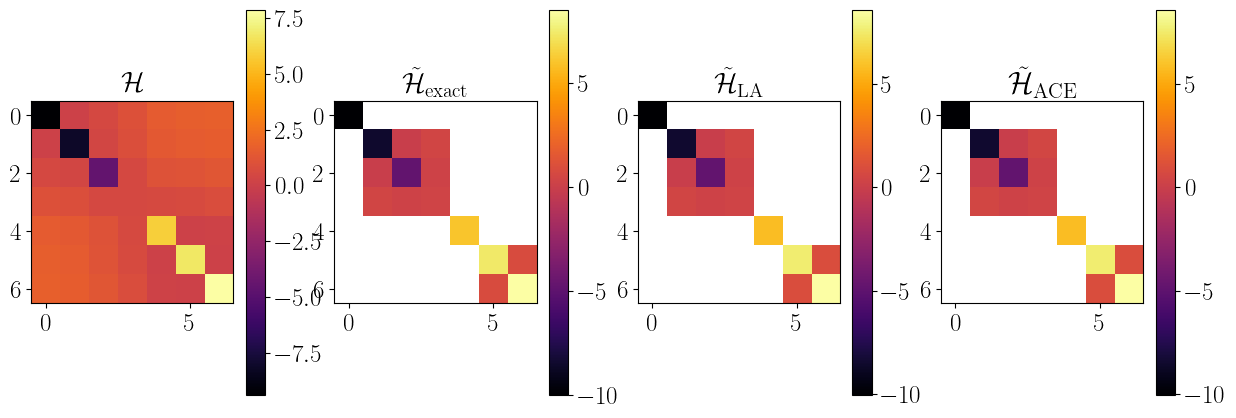

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

im = ax[0].imshow(np.array(Hh, dtype=float), cmap='inferno') # Initial Hamiltonian
fig.colorbar(im, ax=ax[0])
ax[0].set_title(r'$\mathcal{H}$', fontsize=20)

im = ax[1].imshow(exact_result.real, cmap='inferno') # Exact block diagonalization
fig.colorbar(im, ax=ax[1])
ax[1].set_title(r'$\tilde{\mathcal{H}}_\mathrm{exact}$', fontsize=20)

im = ax[2].imshow(np_LA_result.real, cmap='inferno') # LA block diagonalization
fig.colorbar(im, ax=ax[2])
ax[2].set_title(r'$\tilde{\mathcal{H}}_\mathrm{LA}$', fontsize=20)

im = ax[3].imshow(np_ACE_result, cmap='inferno') # ACE block diagonalization
fig.colorbar(im, ax=ax[3])
ax[3].set_title(r'$\tilde{\mathcal{H}}_\mathrm{ACE}$')

# Comparison with exact result

In [38]:
# recomputing exact result
exact_result = la.inv(T) @ np.array(Hh, dtype=float) @ T
# Error function
def fidelity(A, B):
    """Calculates Euclidean norm between matrix A and B"""
    return np.sum(np.abs(A - B))

LA_distances = [fidelity(exact_result, np.array(LA_correction, dtype = float)) for LA_correction in LA_corrections]
ACE_distances = [fidelity(exact_result, np.array(ACE_correction, dtype = float)) for ACE_correction in ACE_corrections]

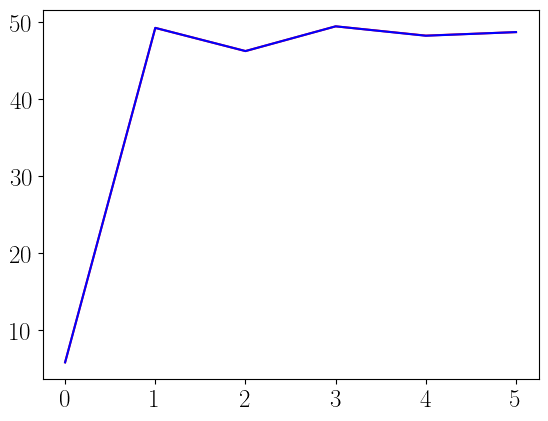

In [39]:
plt.plot(np.arange(0,6), LA_distances, c = "r")
plt.plot(np.arange(0,6), ACE_distances, c = "b")

In [41]:
LA_ACE_distances = [fidelity(np.array(LA_corrections[idx], dtype = float), np.array(ACE_corrections[idx], dtype = float)) for idx in range(6)]

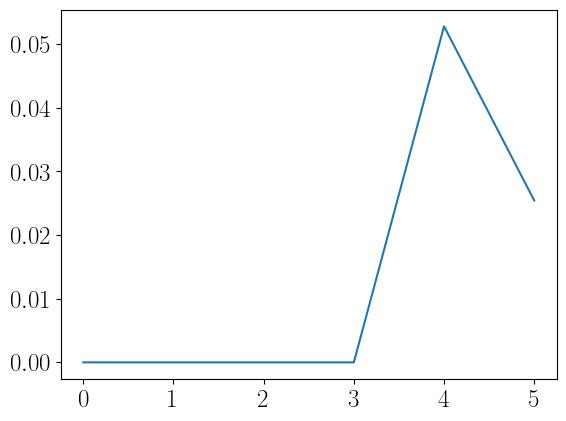

In [42]:
plt.plot(np.arange(0,6), LA_ACE_distances)


In [48]:
LA_ACE_distances[4]

np.float64(0.05280283665335432)